# TEST LOAD MODEL



In [1]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import torchvision

In [2]:
CANTIDAD_CLASES = 2
ANCHO_IMAGENES = 144
ALTO_IMAGENES = 144

In [3]:
class InsectClassifier(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same') # 144 x 144
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # 72 x 72
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # 36 x 36
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # 18 x 18
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # 9 x 9
        self.fc1 = torch.nn.Linear(in_features=128*9*9, out_features=512)       ## MODIF
        #output_units = 1 ## MODIF 
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)  

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        #return x
        return torch.sigmoid(x) ## MODIF 

In [4]:
model = InsectClassifier(CANTIDAD_CLASES)
#model = InsectClassifier().to(device)

In [5]:
# Cargar los pesos entrenados
model.load_state_dict(torch.load('01_nn1_modelo_insectos400.pth'))
model.eval()  # Establecer el modelo en modo de evaluación


InsectClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [6]:
# Definir la transformación de datos para el conjunto de prueba
transform = transforms.Compose([
    transforms.Resize((144, 144)),
    transforms.ToTensor(),
])


In [7]:
from PIL import Image

def preprocesar_imagen(imagen_path):
    transformacion = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    imagen = Image.open(imagen_path)
    print(imagen)
    imagen = transformacion(imagen)
    imagen = imagen.unsqueeze(0)  # Agregar dimensión batch
    return imagen

In [8]:
def predecir_imagen(imagen_path, modelo):
    
    imagen = preprocesar_imagen(imagen_path)

    with torch.no_grad():
        salida = modelo(imagen)
    output = salida.numpy()
    
    c = (max(output[0][0], output[0][1])/(output[0][0] + output[0][1]))

    _, indice_prediccion = torch.max(salida, 1)
    
    return indice_prediccion.item(), c

In [9]:
imagen_path = './dataset_vgg1/test/h/001-18.png'
predecir_imagen(imagen_path, model)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2214DB81040>


(0, 0.99993587)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216C883610>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216C8838B0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216C883C40>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216C883FD0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216C8963A0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216C896730>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216C896AC0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216C896E50>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216D872220>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216D872640>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216D8729D0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=150x150 at 0x2216D872D60>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size

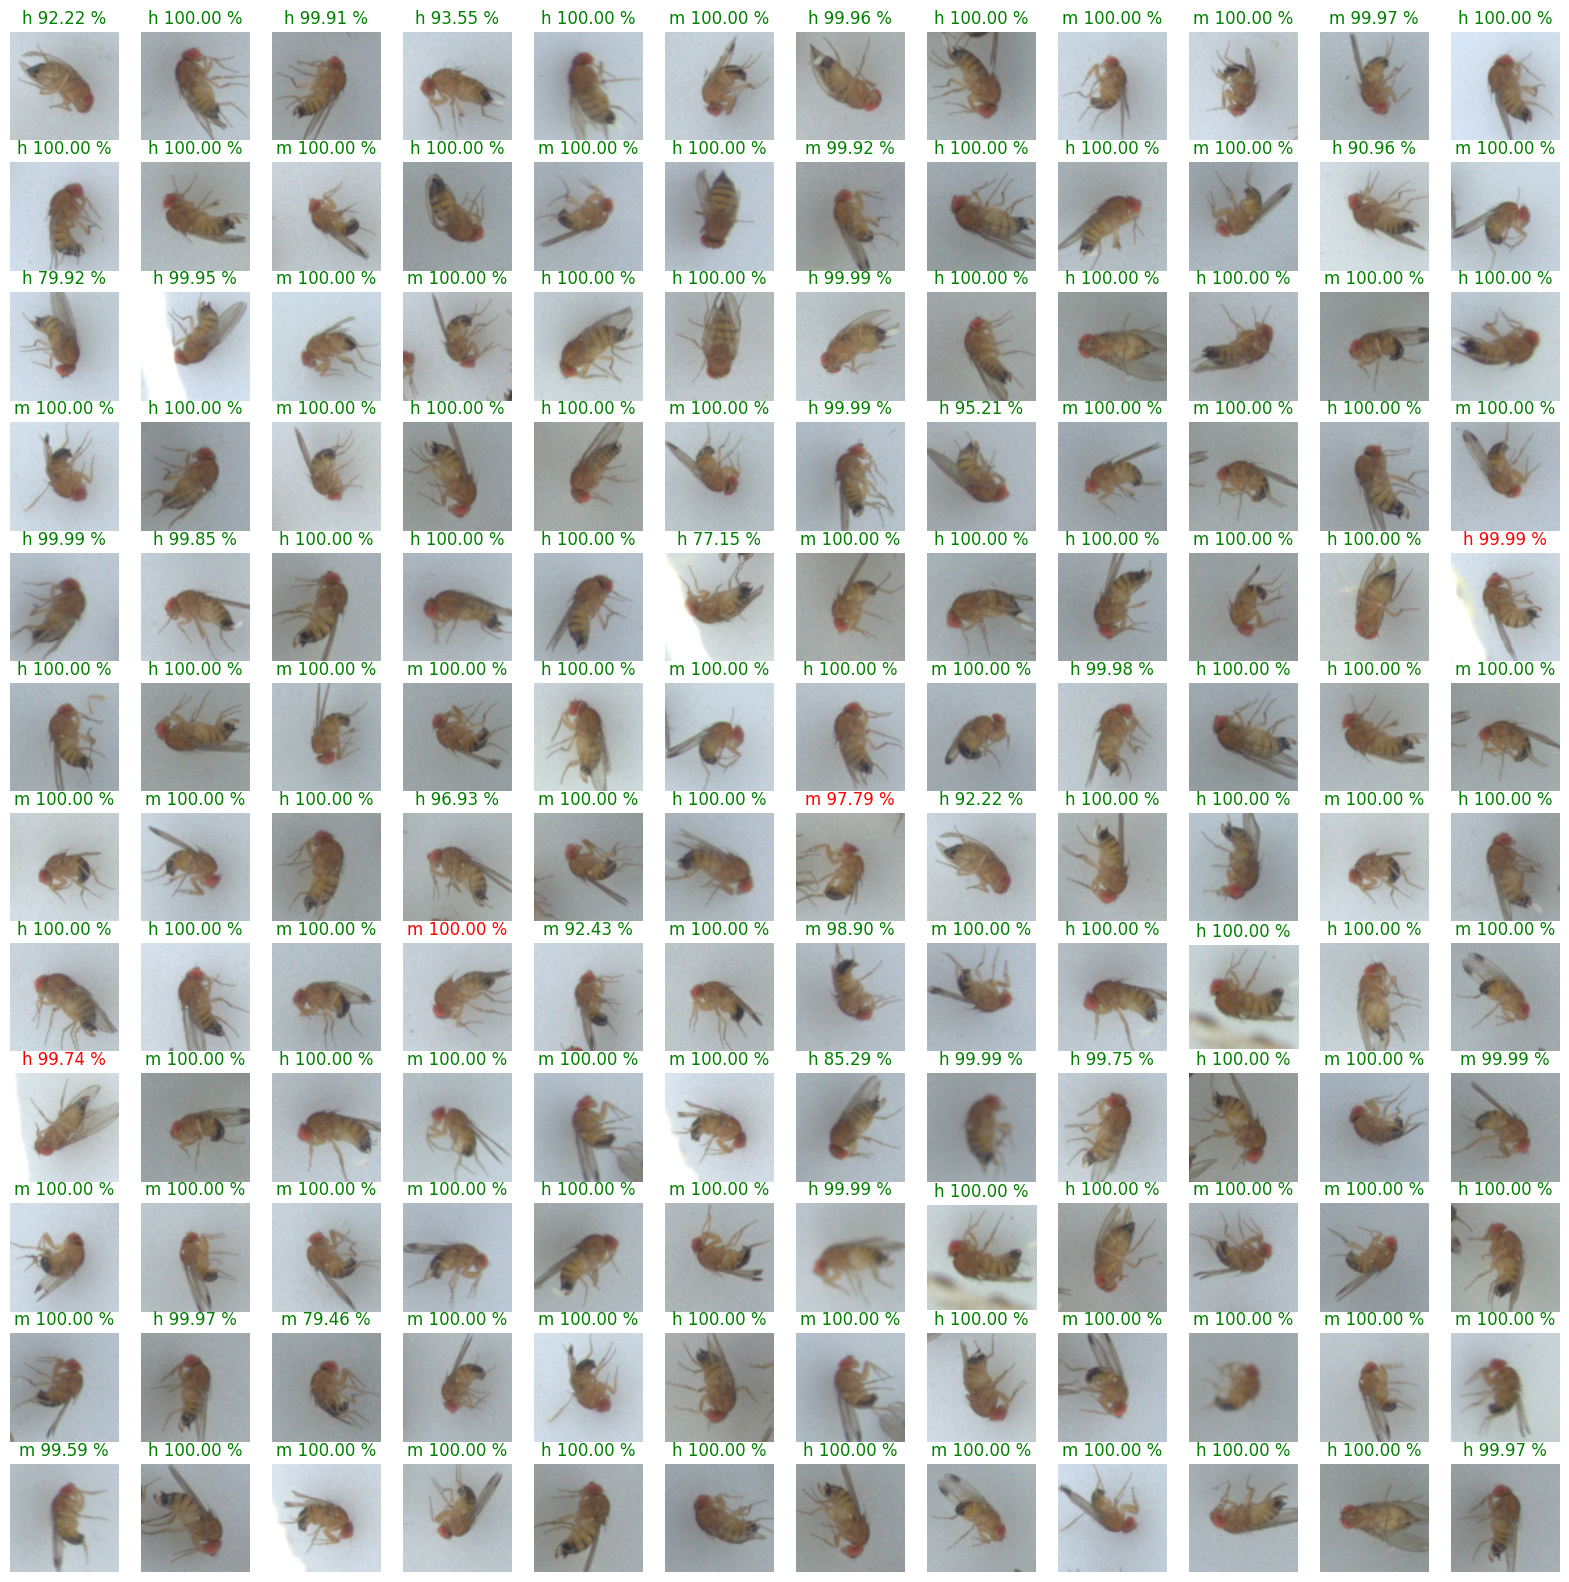

In [10]:
clases = ['h', 'm']

folder = './dataset_vgg1/test/'

r = 12
  
fig, axs = plt.subplots(r, r, figsize=(20, 20))

axs = axs.flatten()
ok = 0
m = 0
h= 0
mp = 0
hp =0 
for i in axs:

        image_h = random.choice(os.listdir(os.path.join(folder, 'h/')))
        image_m = random.choice(os.listdir(os.path.join(folder, 'm/')))

        
        image_name = random.choice([image_h, image_m])
        
        sex = 'm'
        m = m +1
        file = os.path.join(folder, 'm/', image_m)
        if (image_name==image_h): 
            sex = 'h'
            h=h+1
            m=m-1
            file = os.path.join(folder, 'h/', image_h)
    
        indice_prediccion, c = predecir_imagen(file, model)

        c = c*100
        #title = sex + " / PRED: " + clases[indice_prediccion]
        #title = sex + (' (ok)' if sex==clases[indice_prediccion] else ' (err)') + f' {c:.2f} %' 
        title = sex + f' {c:.2f} %' 


        #print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        #epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        fg_color = 'red'
        if sex==clases[indice_prediccion]: 
            fg_color = 'green'
            ok += 1
        test_image = mpimg.imread(file)
        
        if clases[indice_prediccion]=='m': 
            mp += 1
        else:
            hp += 1

        i.imshow(test_image)
        i.set_title(title, color= fg_color)
        i.axis("off")



print(f'Imágenes procesadas: {r**2}')
print(f'Cantidad de machos reales/encontrados: {m} / {mp}')
print(f'Cantidad de hembras reales/encontrados: {h} / {hp}')
print(f'Porcentaje correctos: {(ok/(r**2))*100:.2f} %')